## Data Dictionary
1. date : dates
2. precipitation : All forms in which water falls on the land surface and open water bodies as rain, sleet, snow, hail, or drizzle
3. temp_max : Maximum Temperature
4. temp_min : Minimum Temperature
5. wind : Wind speed
6. weather : weathers types

In [147]:
import os
import re
import sklearn
import numpy as np 
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import *
from sklearn import preprocessing
from sklearn.linear_model import *
from sklearn.model_selection import *
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, SelectFromModel, RFE

In [148]:
#Fetching Data from the Database into a Pandas DataFrame
import sqlite3

conn = sqlite3.connect('normalized.db')

sql_query = """
SELECT d.date as date, p.precipitation as precipitation, t.temperature_max as temp_max, t.temperature_min as temp_min, w.wind as wind, we.weather as weather
FROM Date AS d
JOIN Precipitation AS p ON d.PrecipitationID = p.PrecipitationID
JOIN Temperature AS t ON d.TemperatureID = t.TemperatureID
JOIN Wind AS w ON t.WindID = w.WindID
JOIN Weather AS we ON d.WeatherID = we.WeatherID
"""

df = pd.read_sql_query(sql_query, conn)

conn.close()

df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,3.8,rain
2,2012-01-03,0.8,11.7,7.2,4.7,rain
3,2012-01-04,20.3,12.2,5.6,4.5,rain
4,2012-01-05,1.3,8.9,2.8,4.2,rain


In [149]:
#df= pd.read_csv('seattle-weather.csv')
#df.head()

In [150]:
categorical_columns = df.select_dtypes(include=['object']).columns
categorical_columns

Index(['date', 'weather'], dtype='object')

In [151]:
numerical_columns = df.select_dtypes(include=['int', 'float']).columns
numerical_columns

Index(['precipitation', 'temp_max', 'temp_min', 'wind'], dtype='object')

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [153]:
df.isnull().sum()

date             0
precipitation    0
temp_max         0
temp_min         0
wind             0
weather          0
dtype: int64

In [154]:
df.nunique()

date             1461
precipitation     111
temp_max           67
temp_min           55
wind               71
weather             5
dtype: int64

In [155]:
from ydata_profiling import ProfileReport
profile = ProfileReport(df, title="Profiling Report")
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [156]:
df['date'] = pd.to_datetime(df['date'])

# Create month-wise bins
df['month'] = df['date'].dt.strftime('%m').astype(int)
df['year'] = df['date'].dt.strftime('%y').astype(int)
new_df = df.drop("date", axis='columns')

new_df

,precipitation,temp_max,temp_min,wind,weather,month,year
0,0.0,12.8,5.0,4.7,drizzle,1,12
1,10.9,10.6,2.8,3.8,rain,1,12
2,0.8,11.7,7.2,4.7,rain,1,12
3,20.3,12.2,5.6,4.5,rain,1,12
4,1.3,8.9,2.8,4.2,rain,1,12
...,...,...,...,...,...,...,...
1456,8.6,4.4,1.7,2.9,rain,12,15
1457,1.5,5.0,1.7,1.3,rain,12,15
1458,0.0,7.2,0.6,2.6,fog,12,15
1459,0.0,5.6,-1.0,3.4,sun,12,15


In [157]:
random_seed = 1
np.random.seed(random_seed)

train, test = train_test_split(new_df, test_size=0.3)

print(train.shape)
print(test.shape)

(1022, 7)
(439, 7)


<Figure size 1000x300 with 0 Axes>

/var/folders/99/6y54bc0x23bby_rby5l_l4dh0000gn/T/ipykernel_57167/3423527255.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = 'weather',data = train,palette="ch:start=.2,rot=-.3")


<Axes: xlabel='weather', ylabel='count'>

Text(0.5, 0, 'weather')

Text(0, 0.5, 'Count')

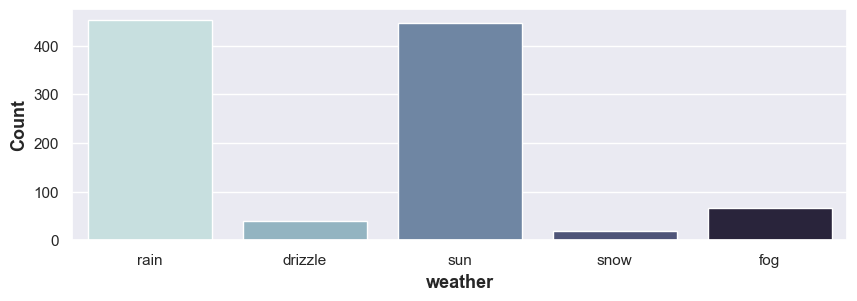

In [158]:
plt.figure(figsize=(10,3))
sns.set_theme()
sns.countplot(x = 'weather',data = train,palette="ch:start=.2,rot=-.3")
plt.xlabel("weather",fontweight='bold',size=13)
plt.ylabel("Count",fontweight='bold',size=13)

/var/folders/99/6y54bc0x23bby_rby5l_l4dh0000gn/T/ipykernel_57167/767794800.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[0, 0],x='weather', y='temp_max', data=train,palette="magma")


<Axes: xlabel='weather', ylabel='temp_max'>

/var/folders/99/6y54bc0x23bby_rby5l_l4dh0000gn/T/ipykernel_57167/767794800.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[0, 1],x='weather', y='temp_min', data=train,palette="magma")


<Axes: xlabel='weather', ylabel='temp_min'>

/var/folders/99/6y54bc0x23bby_rby5l_l4dh0000gn/T/ipykernel_57167/767794800.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[1, 0],x='weather', y='wind', data=train,palette="magma")


<Axes: xlabel='weather', ylabel='wind'>

/var/folders/99/6y54bc0x23bby_rby5l_l4dh0000gn/T/ipykernel_57167/767794800.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(ax=axes[1, 1],x='weather', y='precipitation', data=train,palette="magma")


<Axes: xlabel='weather', ylabel='precipitation'>

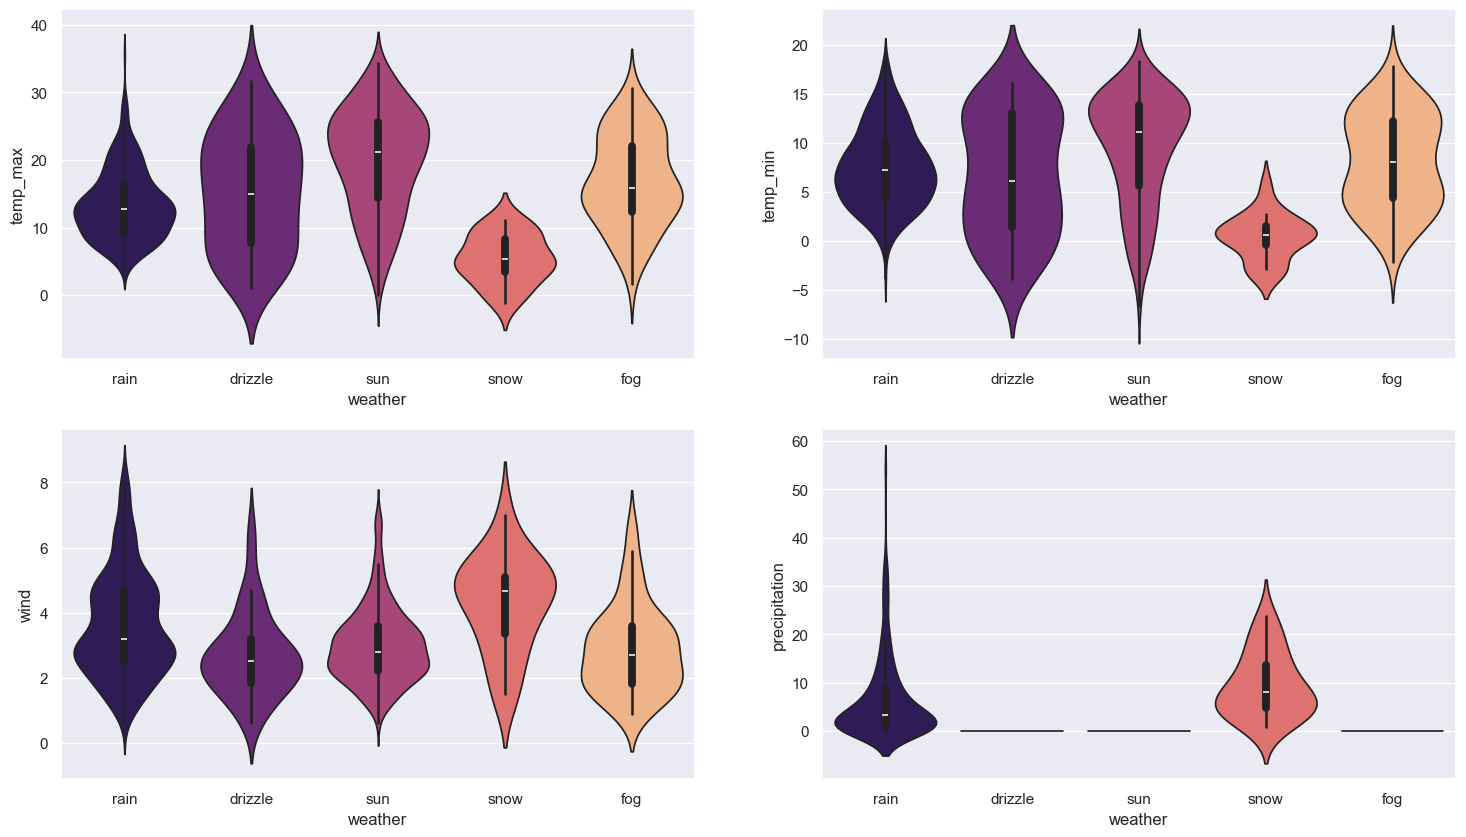

In [159]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
sns.violinplot(ax=axes[0, 0],x='weather', y='temp_max', data=train,palette="magma")
sns.violinplot(ax=axes[0, 1],x='weather', y='temp_min', data=train,palette="magma")
sns.violinplot(ax=axes[1, 0],x='weather', y='wind', data=train,palette="magma")
sns.violinplot(ax=axes[1, 1],x='weather', y='precipitation', data=train,palette="magma")
# sns.boxplot(ax=axes[0, 0],x = 'month',y='temp_max',data=newdf)
# sns.boxplot(ax=axes[0, 1],x = 'month',y='temp_min',data=newdf)
# sns.boxplot(ax=axes[1, 0],x = 'month',y='wind',data=newdf)
# sns.boxplot(ax=axes[1, 1],x = 'month',y='precipitation',data=newdf)

<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

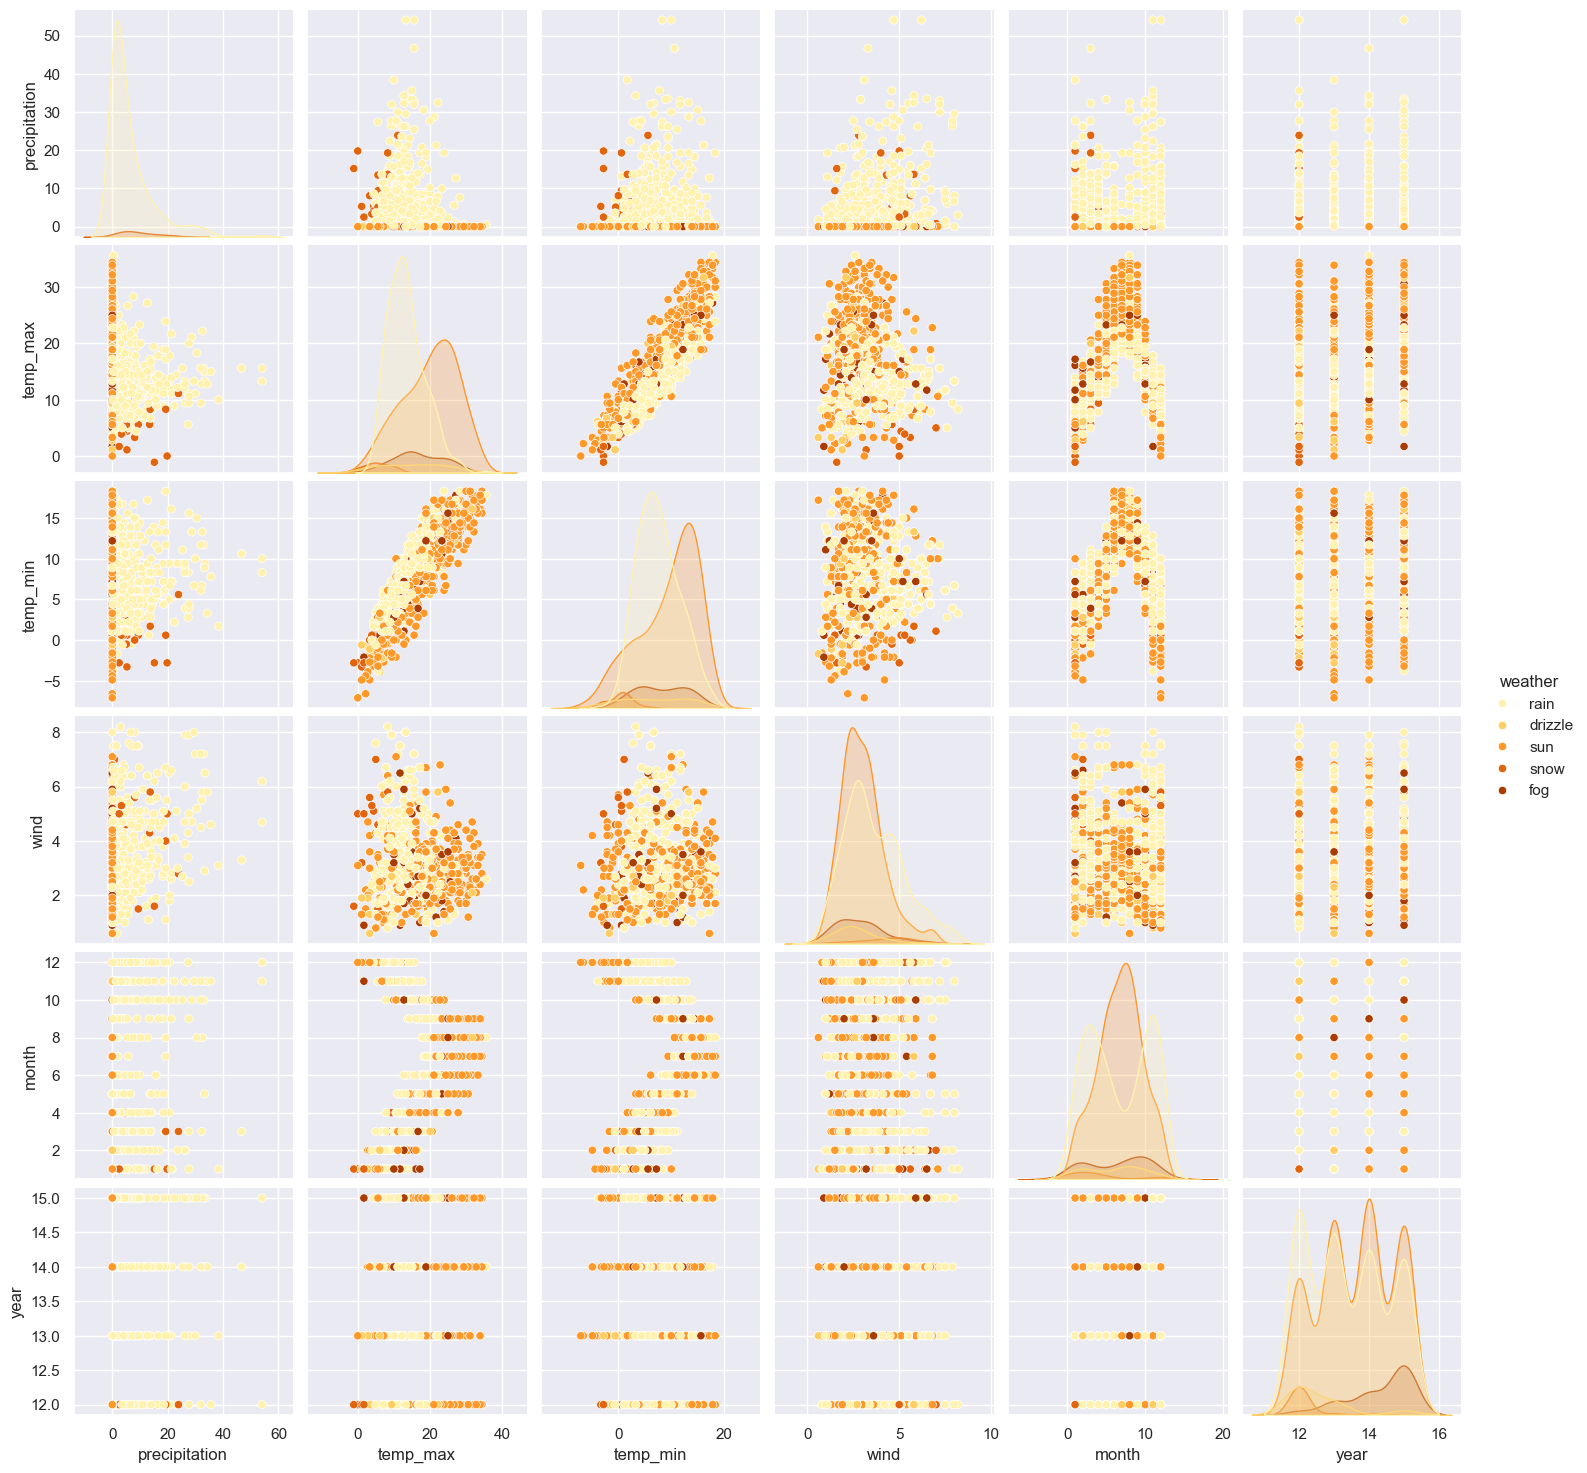

In [160]:
plt.figure(figsize=(14,8))
sns.pairplot(train,hue='weather',palette="YlOrBr")
plt.show()

/var/folders/99/6y54bc0x23bby_rby5l_l4dh0000gn/T/ipykernel_57167/3017995440.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 0],x='month',y ='temp_max',data=train,palette="crest")


<Axes: xlabel='month', ylabel='temp_max'>

/var/folders/99/6y54bc0x23bby_rby5l_l4dh0000gn/T/ipykernel_57167/3017995440.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0, 1],x='month',y ='temp_min',data=train,palette = "RdBu")


<Axes: xlabel='month', ylabel='temp_min'>

/var/folders/99/6y54bc0x23bby_rby5l_l4dh0000gn/T/ipykernel_57167/3017995440.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 0],x='month',y ='wind',data=train,palette = "magma")


<Axes: xlabel='month', ylabel='wind'>

/var/folders/99/6y54bc0x23bby_rby5l_l4dh0000gn/T/ipykernel_57167/3017995440.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1, 1],x='month',y ='precipitation',data=train,palette = "viridis")


<Axes: xlabel='month', ylabel='precipitation'>

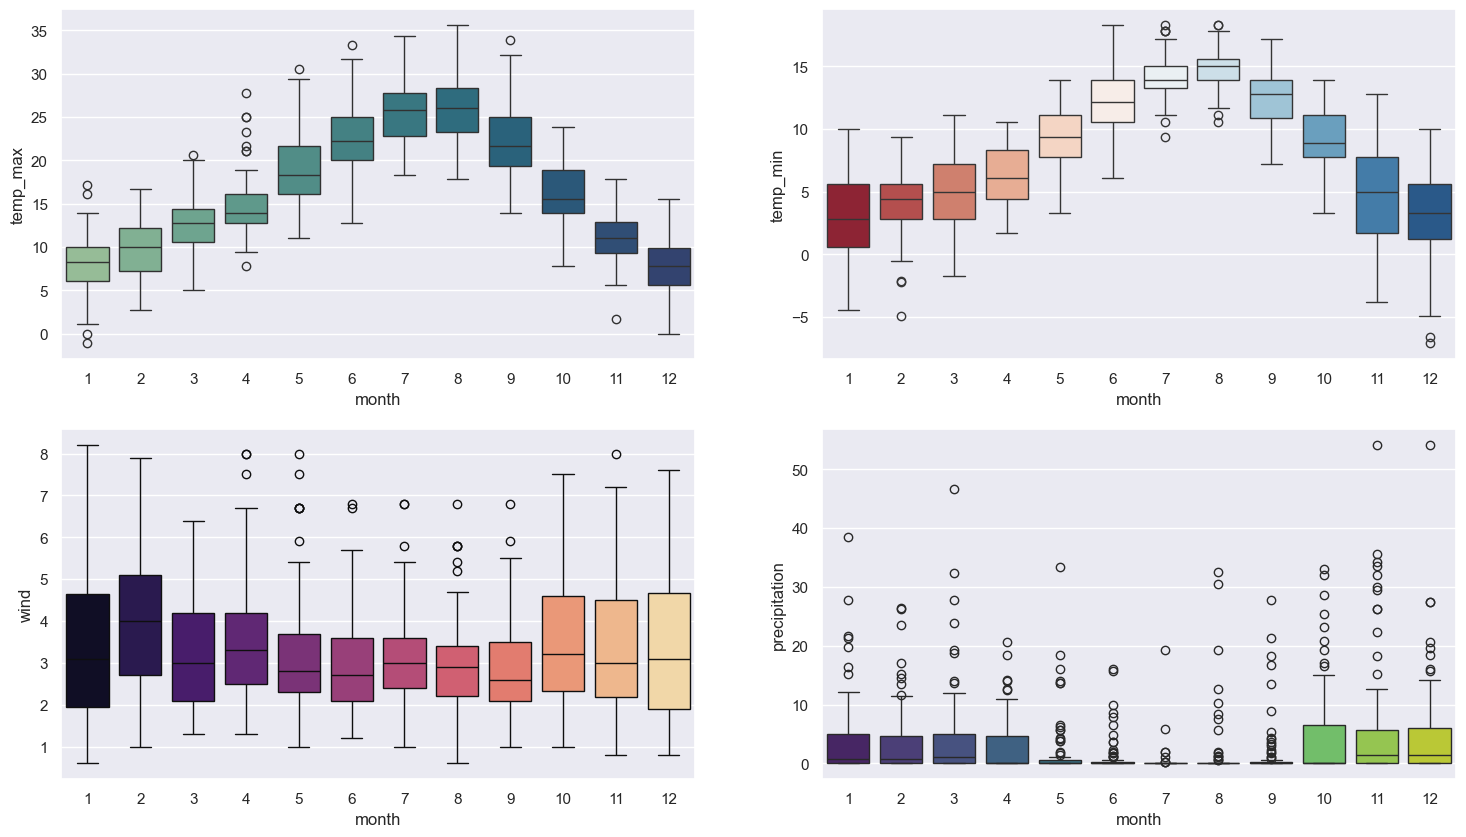

In [161]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
sns.boxplot(ax=axes[0, 0],x='month',y ='temp_max',data=train,palette="crest")
sns.boxplot(ax=axes[0, 1],x='month',y ='temp_min',data=train,palette = "RdBu")
sns.boxplot(ax=axes[1, 0],x='month',y ='wind',data=train,palette = "magma")
sns.boxplot(ax=axes[1, 1],x='month',y ='precipitation',data=train,palette = "viridis")

In [162]:
label_encoder = preprocessing.LabelEncoder() 
new_df['weather']= label_encoder.fit_transform(new_df['weather'])

In [163]:
random_seed = 1
np.random.seed(random_seed)

train, test = train_test_split(new_df, test_size=0.3, random_state=1)

corr_matrix = train.corr(numeric_only=True)
corr_matrix['weather'].sort_values(ascending=False)

weather          1.000000
temp_max         0.330093
temp_min         0.166650
year             0.076949
month            0.036159
wind            -0.090898
precipitation   -0.270003
Name: weather, dtype: float64

Text(0.5, 1.0, 'Correlation Plot')

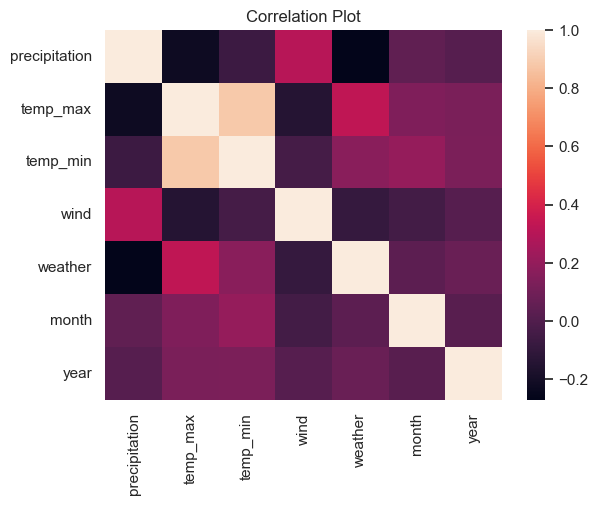

In [164]:
sns.heatmap(train.select_dtypes(exclude='object').corr()).set_title('Correlation Plot')

In [165]:
train.iloc[:, :].describe().T.sort_values(by='std' , ascending = False)\
                     .style.background_gradient(cmap='GnBu')\
                     .bar(subset=["max"], color='#BB0000')\
                     .bar(subset=["mean",], color='green')

,count,mean,std,min,25%,50%,75%,max
temp_max,1022.000000,16.401761,7.408328,-1.100000,10.600000,15.600000,22.200000,35.600000
precipitation,1022.000000,3.076517,6.668362,0.000000,0.000000,0.000000,3.000000,54.100000
temp_min,1022.000000,8.240705,5.085738,-7.100000,4.400000,8.300000,12.200000,18.300000
month,1022.000000,6.594912,3.456217,1.000000,4.000000,7.000000,10.000000,12.000000
wind,1022.000000,3.281018,1.437395,0.600000,2.300000,3.000000,4.100000,8.200000
weather,1022.000000,2.751468,1.192070,0.000000,2.000000,2.000000,4.000000,4.000000
year,1022.000000,13.496086,1.121198,12.000000,12.000000,13.000000,14.750000,15.000000


In [166]:
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()

# X = new_df.drop(columns = ['weather'])
# y = new_df['weather']

# X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [167]:
train

,precipitation,temp_max,temp_min,wind,weather,month,year
674,2.5,13.3,7.2,2.9,2,11,13
1418,2.0,8.9,2.8,4.2,2,11,15
208,0.0,18.9,13.9,1.0,0,7,12
83,0.0,15.0,3.3,1.4,4,3,12
852,0.0,18.3,10.6,2.8,4,5,14
...,...,...,...,...,...,...,...
715,0.3,10.0,4.4,1.0,2,12,13
905,0.0,24.4,14.4,4.4,4,6,14
1096,0.0,5.6,-3.2,1.2,4,1,15
235,0.0,21.1,13.9,1.9,4,8,12


In [168]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
class Preprocessor(BaseEstimator, TransformerMixin):
    numerical_columns = ['precipitation','temp_max','temp_min','wind','month']
    categorical_columns = []
    
    def fit(self, X, y=None):
    # Check if X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X should be a pandas DataFrame.")

        # Check if all numerical columns are present in X
        missing_numerical_columns = set(self.numerical_columns) - set(X.columns)
        if missing_numerical_columns:
            raise ValueError(f"Numerical columns {missing_numerical_columns} not found in X.")

        # Check if all categorical columns are present in X
        missing_categorical_columns = set(self.categorical_columns) - set(X.columns)
        if missing_categorical_columns:
            raise ValueError(f"Categorical columns {missing_categorical_columns} not found in X.")

        # Create and fit simple imputer
        self.imputer = SimpleImputer(strategy='median')
        self.imputer.fit(X[self.numerical_columns])

        # Create and fit Standard Scaler 
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.numerical_columns]) 

        # Create and fit one hot encoder
        self.onehot = OneHotEncoder(handle_unknown='ignore')
        self.onehot.fit(X[self.categorical_columns])

        return self

    def transform(self, X): 
        
        # Apply simple imputer 
        imputed_cols = self.imputer.transform(X[self.numerical_columns])
        onehot_cols = self.onehot.transform(X[self.categorical_columns])
        
        # Copy the df 
        transformed_df = X.copy()
         
        # Apply transformed columns
        transformed_df[self.numerical_columns] = imputed_cols
        transformed_df[self.numerical_columns] = self.scaler.transform(transformed_df[self.numerical_columns])        
        
        # Drop existing categorical columns and replace with one hot equiv
        transformed_df = transformed_df.drop(self.categorical_columns, axis=1) 
        transformed_df[self.onehot.get_feature_names_out()] = onehot_cols.toarray().astype(int)
        
        return transformed_df

In [169]:
transformed_data=Preprocessor()
transformed_data

Preprocessor()

In [170]:
X_train = train.drop('weather', axis=1)
y_train = train['weather']
preproc = Preprocessor()
preproc.fit(X_train)
preprocessed_df = preproc.transform(X_train)
preprocessed_df.head()

Preprocessor()

,precipitation,temp_max,temp_min,wind,month,year
674,-0.086498,-0.418891,-0.204732,-0.265205,1.275164,13
1418,-0.161515,-1.013108,-1.070320,0.639652,1.275164,15
208,-0.461586,0.337385,1.113323,-1.587688,0.117263,12
83,-0.461586,-0.189307,-0.971958,-1.309271,-1.040638,12
852,-0.461586,0.256356,0.464131,-0.334809,-0.461688,14


In [171]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

rfc = RandomForestClassifier()
svm = SVC(probability=True)
nb = GaussianNB()
logistic = LogisticRegression()
dt = DecisionTreeClassifier()

rfc_base_pipeline = make_pipeline(Preprocessor(), rfc)
svm_base_pipeline = make_pipeline(Preprocessor(), StandardScaler(), svm)
nb_base_pipeline = make_pipeline(Preprocessor(), nb)
logistic_base_pipeline = make_pipeline(Preprocessor(), StandardScaler(), logistic)
dt_base_pipeline = make_pipeline(Preprocessor(), dt)

rfc_base_pipeline.fit(X_train, y_train)
svm_base_pipeline.fit(X_train, y_train)
nb_base_pipeline.fit(X_train, y_train)
logistic_base_pipeline.fit(X_train, y_train)
dt_base_pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocessor', Preprocessor()),
                ('randomforestclassifier', RandomForestClassifier())])

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))])

Pipeline(steps=[('preprocessor', Preprocessor()), ('gaussiannb', GaussianNB())])

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

Pipeline(steps=[('preprocessor', Preprocessor()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [172]:
X_test = test.drop('weather', axis=1)
y_test = test['weather']
print(X_test)
print(y_test)

      precipitation  temp_max  temp_min  wind  month  year
1374            0.0      18.3      10.0   2.6     10    15
885             0.0      19.4      10.0   2.0      6    14
414             0.0       7.8       3.9   1.6      2    13
1003            0.0      19.4      12.2   2.6      9    14
201            15.2      19.4      13.9   5.0      7    12
...             ...       ...       ...   ...    ...   ...
498             3.3      18.9       9.4   5.0      5    13
1119            0.5      14.4      11.1   3.3      1    15
1129            1.3      10.0       5.6   1.9      2    15
1173            0.0      15.6       8.3   2.7      3    15
1168           17.0      13.9       9.4   3.8      3    15

[439 rows x 6 columns]
1374    0
885     4
414     2
1003    4
201     2
       ..
498     2
1119    2
1129    2
1173    4
1168    2
Name: weather, Length: 439, dtype: int64


In [178]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import pandas as pd  


models = [rfc_base_pipeline, svm_base_pipeline, nb_base_pipeline, logistic_base_pipeline, dt_base_pipeline]


model_names = ["Random Forest", "SVM", "Naive Bayes", "Logistic Regression", "Decision Tree"]
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_auc_scores = []
confusion_matrices = []

# Evaluate each model
for model in models:
    # Predict probabilities on test data
    y_pred_proba = model.predict_proba(X_test)
    # Convert probabilities to class predictions
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
    cm = confusion_matrix(y_test, y_pred)
    
    # Append metrics to lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    confusion_matrices.append(cm)

# Create a DataFrame to display the evaluation metrics
evaluation_metrics = {
    "Model": model_names,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1 Score": f1_scores,
    "ROC AUC Score": roc_auc_scores
}
ev = pd.DataFrame(evaluation_metrics)


/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [179]:
ev

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,Random Forest,0.854214,0.823913,0.854214,0.822495,0.945136
1,SVM,0.763098,0.696748,0.763098,0.715374,0.901163
2,Naive Bayes,0.829157,0.832863,0.829157,0.811263,0.926780
3,Logistic Regression,0.783599,0.693566,0.783599,0.732524,0.912646
4,Decision Tree,0.804100,0.817075,0.804100,0.809958,0.864239


In [180]:
params_log_base = logistic_base_pipeline.get_params()
params_log_base

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

<Experiment: artifact_location='mlflow-artifacts:/2740289dc4fc4aa5ae6112ee8b698550', creation_time=1715927277196, experiment_id='0', last_update_time=1715927277196, lifecycle_stage='active', name='Predict Seattle Weather', tags={}>

Preprocessor()

/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Base Logistic model' already exists. Creating a new version of this model...
2024/05/17 02:28:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 0, 'Predicted labels')

Text(0, 0.5, 'True labels')

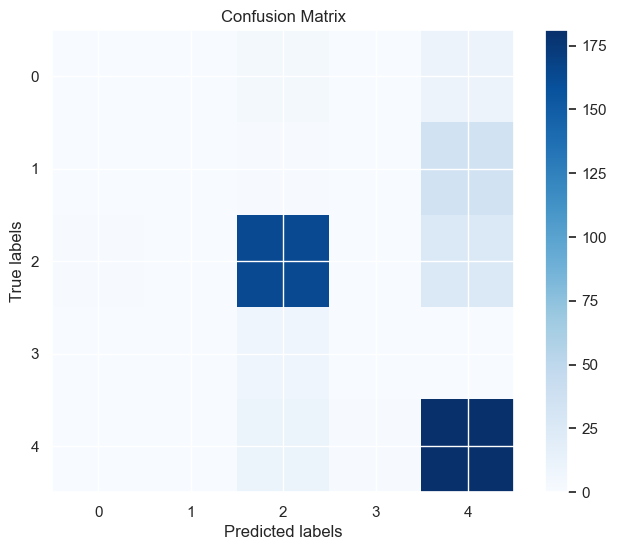

In [182]:
import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
MLFLOW_TRACKING_URI="https://dagshub.com/pranavi.chintala05/seattle_weather_prediction.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="pranavi.chintala05"
os.environ['MLFLOW_TRACKING_PASSWORD']="12345678"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)



# Create a new MLflow Experiment
mlflow.set_experiment("Predict Seattle Weather")

# Instantiate Preprocessor_fe and fit it to the data
preprocessor = Preprocessor()
preprocessor.fit(X_train)

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_log_base)

    # Log metrics
    mlflow.log_metric('recall_score', recalls[3])
    mlflow.log_metric('f1_score', f1_scores[3])
    mlflow.log_metric("precision_score", precisions[3])
    mlflow.log_metric("Accuracy", accuracies[3])
    mlflow.log_metric("roc_auc_score", roc_auc_scores[3])
    
    
    
    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Base Logistic Regression model")
    

    # Infer the model signature
    signature = infer_signature(X_train, logistic_base_pipeline.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=logistic_base_pipeline,
        artifact_path="seattle_weather_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="Base Logistic model",
    )
    y_pred = logistic_base_pipeline.predict(X_test)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    true_negatives = conf_matrix[0][0]
    false_positives = conf_matrix[0][1]
    false_negatives = conf_matrix[1][0]
    true_positives = conf_matrix[1][1]


    # Log the metrics
    mlflow.log_metric("true_negatives", true_negatives)
    mlflow.log_metric("false_positives", false_positives)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("true_positives", true_positives)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    # Save the confusion matrix plot as an image file
    conf_matrix_image_path = "logistic_base_pipeline_confusion_matrix.png"
    plt.savefig(conf_matrix_image_path)
    plt.show()
    plt.close()

    mlflow.log_artifact(conf_matrix_image_path, "logistic_base_pipeline_confusion_matrix")
    


In [183]:
params_rf_base= rfc_base_pipeline.get_params()
params_rf_base

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'randomforestclassifier': RandomForestClassifier(),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__n_jobs': None,
 'randomforestclassifier__oob_score': False,
 'randomforestclassifier__random_state': None,
 'randomforestclass

Preprocessor()

/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Base Random Forest model'.
2024/05/17 02:28:57 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Base Random Forest mode

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 0, 'Predicted labels')

Text(0, 0.5, 'True labels')

([<matplotlib.axis.XTick at 0x2aaaacbd0>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Positive')])

([<matplotlib.axis.YTick at 0x2aaaa8ad0>,
 [Text(0, 0, 'Negative'), Text(0, 1, 'Positive')])

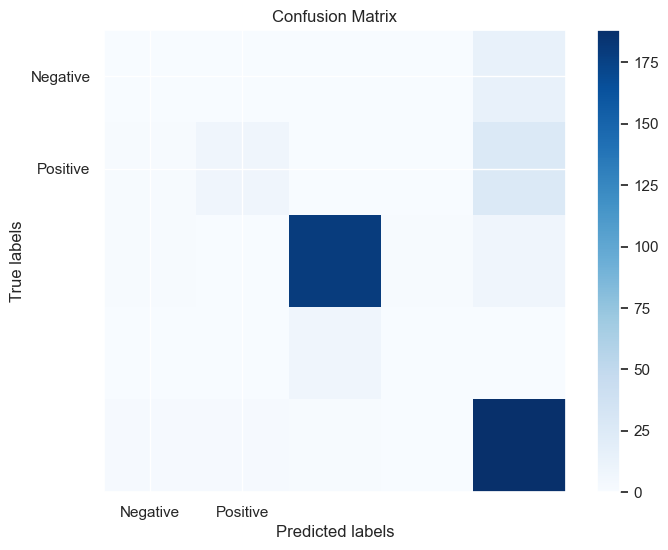

In [184]:
import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
MLFLOW_TRACKING_URI="https://dagshub.com/pranavi.chintala05/seattle_weather_prediction.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="pranavi.chintala05"
os.environ['MLFLOW_TRACKING_PASSWORD']="12345678"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Instantiate Preprocessor_fe and fit it to the data
preprocessor = Preprocessor()
preprocessor.fit(X_train)

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_rf_base)

    # Log metrics
    mlflow.log_metric('recall_score', recalls[0])
    mlflow.log_metric('f1_score', f1_scores[0])
    mlflow.log_metric("precision_score", precisions[0])
    mlflow.log_metric("Accuracy", accuracies[0])
    mlflow.log_metric("roc_auc_score", roc_auc_scores[0])
    

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Base Random Forest Model")


    # Infer the model signature
    signature = infer_signature(X_train, rfc_base_pipeline.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rfc_base_pipeline,
        artifact_path="seattle_weather_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="Base Random Forest model",
    )
    y_pred = rfc_base_pipeline.predict(X_test)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    true_negatives = conf_matrix[0][0]
    false_positives = conf_matrix[0][1]
    false_negatives = conf_matrix[1][0]
    true_positives = conf_matrix[1][1]

    # Log the metrics
    mlflow.log_metric("true_negatives", true_negatives)
    mlflow.log_metric("false_positives", false_positives)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("true_positives", true_positives)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

    # Save the confusion matrix plot as an image file
    conf_matrix_image_path = "base_rfc_confusion_matrix.png"
    plt.savefig(conf_matrix_image_path)

    # Log the confusion matrix image as a custom metric in MLflow
    mlflow.log_artifact(conf_matrix_image_path, "base_rfc_confusion_matrix")

In [185]:
params_svm_base = svm_base_pipeline.get_params()
params_svm_base

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('standardscaler', StandardScaler()),
  ('svc', SVC(probability=True))],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'standardscaler': StandardScaler(),
 'svc': SVC(probability=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

Preprocessor()

/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Base Support Vector model'.
2024/05/17 02:29:09 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Base Support Vector mo

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 0, 'Predicted labels')

Text(0, 0.5, 'True labels')

([<matplotlib.axis.XTick at 0x2a9401210>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Positive')])

([<matplotlib.axis.YTick at 0x2a93cc8d0>,
 [Text(0, 0, 'Negative'), Text(0, 1, 'Positive')])

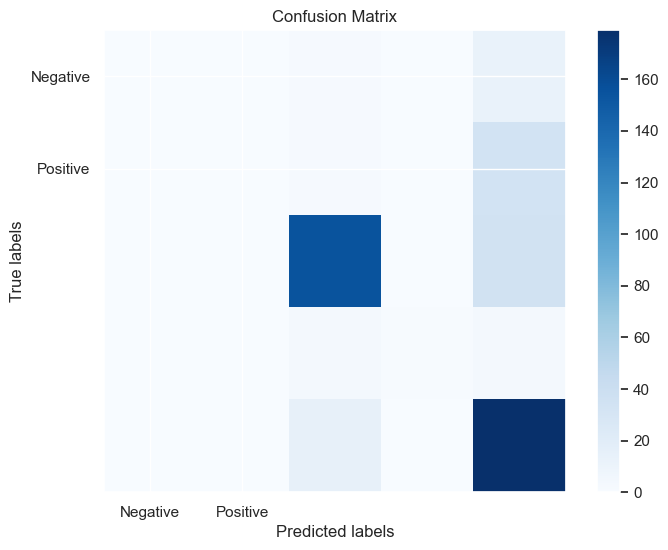

In [186]:
import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
# Set our tracking server uri for logging
MLFLOW_TRACKING_URI="https://dagshub.com/pranavi.chintala05/seattle_weather_prediction.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="pranavi.chintala05"
os.environ['MLFLOW_TRACKING_PASSWORD']="12345678"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
# Instantiate Preprocessor_fe and fit it to the data
preprocessor = Preprocessor()
preprocessor.fit(X_train)

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_svm_base)

    # Log metrics
    mlflow.log_metric('recall_score', recalls[1])
    mlflow.log_metric('f1_score', f1_scores[1])
    mlflow.log_metric("precision_score", precisions[1])
    mlflow.log_metric("Accuracy", accuracies[1])
    mlflow.log_metric("roc_auc_score", roc_auc_scores[1])
    

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Support Vector model")


    # Infer the model signature
    signature = infer_signature(X_train, svm_base_pipeline.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=svm_base_pipeline,
        artifact_path="seattle_weather_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="Base Support Vector model",
    )
    y_pred = svm_base_pipeline.predict(X_test)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    true_negatives = conf_matrix[0][0]
    false_positives = conf_matrix[0][1]
    false_negatives = conf_matrix[1][0]
    true_positives = conf_matrix[1][1]

    # Log the metrics
    mlflow.log_metric("true_negatives", true_negatives)
    mlflow.log_metric("false_positives", false_positives)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("true_positives", true_positives)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

    # Save the confusion matrix plot as an image file
    conf_matrix_image_path = "base_svm_confusion_matrix.png"
    plt.savefig(conf_matrix_image_path)

    # Log the confusion matrix image as a custom metric in MLflow
    mlflow.log_artifact(conf_matrix_image_path, "Base_svm_confusion_matrix")

In [187]:
params_nb_base = nb_base_pipeline.get_params()
params_nb_base

{'memory': None,
 'steps': [('preprocessor', Preprocessor()), ('gaussiannb', GaussianNB())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'gaussiannb': GaussianNB(),
 'gaussiannb__priors': None,
 'gaussiannb__var_smoothing': 1e-09}

Preprocessor()

/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Base Naive Bayes model'.
2024/05/17 02:29:21 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Base Naive Bayes model, v

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 0, 'Predicted labels')

Text(0, 0.5, 'True labels')

([<matplotlib.axis.XTick at 0x2a4532010>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Positive')])

([<matplotlib.axis.YTick at 0x2a4530550>,
 [Text(0, 0, 'Negative'), Text(0, 1, 'Positive')])

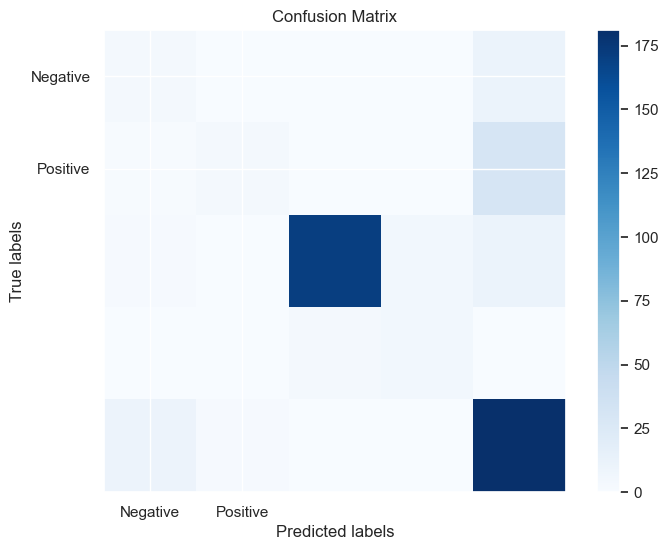

In [188]:
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import confusion_matrix


# Set our tracking server uri for logging
# Set our tracking server uri for logging
MLFLOW_TRACKING_URI="https://dagshub.com/pranavi.chintala05/seattle_weather_prediction.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="pranavi.chintala05"
os.environ['MLFLOW_TRACKING_PASSWORD']="12345678"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Instantiate Preprocessor_fe and fit it to the data
preprocessor = Preprocessor()
preprocessor.fit(X_train)

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_nb_base)
    # Log metrics
    mlflow.log_metric('recall_score', recalls[2])
    mlflow.log_metric('f1_score', f1_scores[2])
    mlflow.log_metric("precision_score", precisions[2])
    mlflow.log_metric("Accuracy", accuracies[2])
    mlflow.log_metric("roc_auc_score", roc_auc_scores[2])
    

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Base Naive Bayes model")


    # Infer the model signature
    signature = infer_signature(X_train,  nb_base_pipeline.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model= nb_base_pipeline,
        artifact_path="seattle_weather_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="Base Naive Bayes model",
    )
    y_pred = nb_base_pipeline.predict(X_test)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    true_negatives = conf_matrix[0][0]
    false_positives = conf_matrix[0][1]
    false_negatives = conf_matrix[1][0]
    true_positives = conf_matrix[1][1]

    # Log the metrics
    mlflow.log_metric("true_negatives", true_negatives)
    mlflow.log_metric("false_positives", false_positives)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("true_positives", true_positives)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

    # Save the confusion matrix plot as an image file
    conf_matrix_image_path = "base_nb_confusion_matrix.png"
    plt.savefig(conf_matrix_image_path)

    # Log the confusion matrix image as a custom metric in MLflow
    mlflow.log_artifact(conf_matrix_image_path, "base_nb_confusion_matrix")


In [189]:
params_dt_base = dt_base_pipeline.get_params()
params_dt_base

{'memory': None,
 'steps': [('preprocessor', Preprocessor()),
  ('decisiontreeclassifier', DecisionTreeClassifier())],
 'verbose': False,
 'preprocessor': Preprocessor(),
 'decisiontreeclassifier': DecisionTreeClassifier(),
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__random_state': None,
 'decisiontreeclassifier__splitter': 'best'}

Preprocessor()

/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Base Decision Tree model'.
2024/05/17 02:29:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Base Decision Tree mode

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 0, 'Predicted labels')

Text(0, 0.5, 'True labels')

([<matplotlib.axis.XTick at 0x2aaf65a50>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Positive')])

([<matplotlib.axis.YTick at 0x2a454f1d0>,
 [Text(0, 0, 'Negative'), Text(0, 1, 'Positive')])

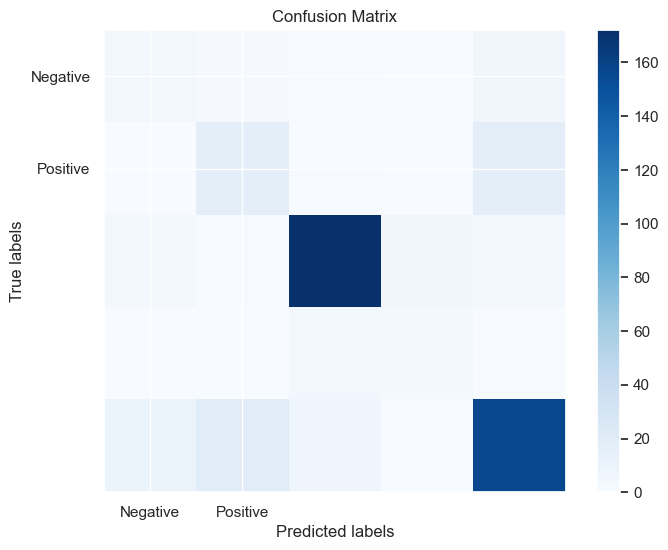

In [190]:
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import confusion_matrix


# Set our tracking server uri for logging
# Set our tracking server uri for logging
MLFLOW_TRACKING_URI="https://dagshub.com/pranavi.chintala05/seattle_weather_prediction.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="pranavi.chintala05"
os.environ['MLFLOW_TRACKING_PASSWORD']="12345678"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Instantiate Preprocessor_fe and fit it to the data
preprocessor = Preprocessor()
preprocessor.fit(X_train)

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_dt_base)
    # Log metrics
    mlflow.log_metric('recall_score', recalls[4])
    mlflow.log_metric('f1_score', f1_scores[4])
    mlflow.log_metric("precision_score", precisions[4])
    mlflow.log_metric("Accuracy", accuracies[4])
    mlflow.log_metric("roc_auc_score", roc_auc_scores[4])
    

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Base Decision Tree model")


    # Infer the model signature
    signature = infer_signature(X_train,  dt_base_pipeline.predict(X_train))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model= dt_base_pipeline,
        artifact_path="seattle_weather_model",
        signature=signature,
        input_example=preprocessor.transform(X_train),
        registered_model_name="Base Decision Tree model",
    )
    y_pred = dt_base_pipeline.predict(X_test)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    true_negatives = conf_matrix[0][0]
    false_positives = conf_matrix[0][1]
    false_negatives = conf_matrix[1][0]
    true_positives = conf_matrix[1][1]

    # Log the metrics
    mlflow.log_metric("true_negatives", true_negatives)
    mlflow.log_metric("false_positives", false_positives)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("true_positives", true_positives)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

    # Save the confusion matrix plot as an image file
    conf_matrix_image_path = "base_dt_confusion_matrix.png"
    plt.savefig(conf_matrix_image_path)

    # Log the confusion matrix image as a custom metric in MLflow
    mlflow.log_artifact(conf_matrix_image_path, "base_dt_confusion_matrix")


In [191]:
df['weather']= label_encoder.fit_transform(df['weather']) 

scaler = StandardScaler()
scaled_data = scaler.fit_transform(new_df)

pca = PCA(n_components=1) 
principal_components = pca.fit_transform(scaled_data)

principal_df = pd.DataFrame(data=principal_components, columns=['PC1'])

df = pd.concat([new_df, principal_df], axis=1)

In [192]:
def add_monthly_and_yearly_averages(df, columns):

    monthly_averages = df.groupby(['year', 'month'])[columns].mean()
    df = df.merge(monthly_averages, on=['year', 'month'], suffixes=('', '_mon_avg'))
    
    yearly_averages = df.groupby('year')[columns].mean()
    df = df.merge(yearly_averages, on='year', suffixes=('', '_year_avg'))
    
    return df

cols = ['precipitation', 'temp_max', 'temp_min', 'wind']
df = add_monthly_and_yearly_averages(df, cols)


In [193]:
temperature_bins = [-10, 5, 10, 15, 20, 40]   
temperature_labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']  

df['temp_min_category'] = pd.cut(df['temp_min'], bins=temperature_bins, labels=temperature_labels)
df['temp_max_category'] = pd.cut(df['temp_max'], bins=temperature_bins, labels=temperature_labels)

def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'
    
df['season'] = df['month'].apply(get_season)


In [194]:
df['temp_max_wind_interaction'] = df['temp_max'] * df['wind']
df['temp_min_wind_interaction'] = df['temp_min'] * df['wind']
df['precipitation_wind_interaction'] = df['precipitation'] * df['wind']
df['temp_max_prec_interaction'] = df['temp_max'] * df['precipitation']
df['temp_min_prec_interaction'] = df['temp_min'] * df['precipitation']

In [195]:
df_fe = df

In [196]:
df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   precipitation                   1461 non-null   float64 
 1   temp_max                        1461 non-null   float64 
 2   temp_min                        1461 non-null   float64 
 3   wind                            1461 non-null   float64 
 4   weather                         1461 non-null   int64   
 5   month                           1461 non-null   int64   
 6   year                            1461 non-null   int64   
 7   PC1                             1461 non-null   float64 
 8   precipitation_mon_avg           1461 non-null   float64 
 9   temp_max_mon_avg                1461 non-null   float64 
 10  temp_min_mon_avg                1461 non-null   float64 
 11  wind_mon_avg                    1461 non-null   float64 
 12  precipitation_year_a

In [197]:
df_fe['temp_min_category']= label_encoder.fit_transform(df_fe['temp_min_category'])
df_fe['temp_max_category']= label_encoder.fit_transform(df_fe['temp_max_category'])
df_fe['season']= label_encoder.fit_transform(df_fe['season'])

In [198]:
class FeatureSelector:
    def __init__(self, data):
        self.data = data
        self.X = data.drop(columns=['weather'])
        self.y = data['weather']
    
    def filter_method(self, top_n=None):
        corr_matrix = self.data.corr()
        target_correlation = abs(corr_matrix['weather']).sort_values(ascending=False)
        selected_features_filter = target_correlation.index[1:top_n+1]
        return selected_features_filter
    
    def wrapper_method(self, top_n=None):
        model = LogisticRegression()
        rfe = RFE(model, n_features_to_select=top_n)
        rfe.fit(self.X, self.y)
        selected_features_wrapper = self.X.columns[rfe.support_]
        return selected_features_wrapper
    
    def embedded_method(self, top_n=None):
        model = LogisticRegression(penalty='l1', solver='liblinear', random_state=0)
        embedded_selector = SelectFromModel(model)
        embedded_selector.fit(self.X, self.y)
        selected_features_embedded = self.X.columns[embedded_selector.get_support()]
        return selected_features_embedded
    
    def hybrid_selection(self, top_n=None):
        filter_features = self.filter_method(top_n)
        wrapper_features = self.wrapper_method(top_n)
        embedded_features = self.embedded_method(top_n)
        
        # Combine features from all methods and remove duplicates
        hybrid_features = list(set(filter_features) | set(wrapper_features) | set(embedded_features))
        
        # Select top_n features if more than top_n features are selected
        if len(hybrid_features) > top_n:
            hybrid_features = hybrid_features[:top_n]
        
        return hybrid_features

In [199]:
selector = FeatureSelector(df)

print("Selected Features (Hybrid Method):")
print(selector.hybrid_selection(top_n=20))

Selected Features (Hybrid Method):


/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

['wind', 'precipitation_wind_interaction', 'precipitation', 'year', 'PC1', 'precipitation_mon_avg', 'temp_min', 'temp_min_category', 'temp_min_prec_interaction', 'temp_min_wind_interaction', 'temp_max_category', 'temp_max_year_avg', 'wind_year_avg', 'precipitation_year_avg', 'temp_max', 'season', 'temp_min_year_avg', 'month', 'temp_max_wind_interaction', 'wind_mon_avg']


In [200]:
df_fe1 = df_fe[['PC1', 'temp_max_prec_interaction', 'temp_min_category', 'temp_min_wind_interaction', 'temp_max_mon_avg', 'precipitation_mon_avg', 'temp_min_mon_avg', 'precipitation_wind_interaction', 'wind_mon_avg', 'temp_max_year_avg', 'precipitation_year_avg', 'temp_max', 'temp_min', 'wind_year_avg', 'temp_max_wind_interaction', 'year', 'temp_min_year_avg', 'temp_max_category', 'month', 'wind', 'weather']]

In [201]:
random_seed = 1
np.random.seed(random_seed)

train_fe, test_fe = train_test_split(df_fe1, test_size=0.3, random_state=1)

In [202]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
class Preprocessor_fe(BaseEstimator, TransformerMixin):
    numerical_columns = ['PC1', 'temp_max_prec_interaction', 'temp_min_category', 'temp_min_wind_interaction', 'temp_max_mon_avg', 'precipitation_mon_avg', 'temp_min_mon_avg', 'precipitation_wind_interaction', 'wind_mon_avg', 'temp_max_year_avg', 'precipitation_year_avg', 'temp_max', 'temp_min', 'wind_year_avg', 'temp_max_wind_interaction', 'year', 'temp_min_year_avg', 'temp_max_category', 'month', 'wind']
    categorical_columns = []
    
    def fit(self, X, y=None):
    # Check if X is a DataFrame
        if not isinstance(X, pd.DataFrame):
            raise ValueError("X should be a pandas DataFrame.")

        # Check if all numerical columns are present in X
        missing_numerical_columns = set(self.numerical_columns) - set(X.columns)
        if missing_numerical_columns:
            raise ValueError(f"Numerical columns {missing_numerical_columns} not found in X.")

        # Check if all categorical columns are present in X
        missing_categorical_columns = set(self.categorical_columns) - set(X.columns)
        if missing_categorical_columns:
            raise ValueError(f"Categorical columns {missing_categorical_columns} not found in X.")

        # Create and fit simple imputer
        self.imputer = SimpleImputer(strategy='median')
        self.imputer.fit(X[self.numerical_columns])

        # Create and fit Standard Scaler 
        self.scaler = StandardScaler()
        self.scaler.fit(X[self.numerical_columns]) 

        # Create and fit one hot encoder
        self.onehot = OneHotEncoder(handle_unknown='ignore')
        self.onehot.fit(X[self.categorical_columns])

        return self

    def transform(self, X): 
        
        # Apply simple imputer 
        imputed_cols = self.imputer.transform(X[self.numerical_columns])
        onehot_cols = self.onehot.transform(X[self.categorical_columns])
        
        # Copy the df 
        transformed_df = X.copy()
         
        # Apply transformed columns
        transformed_df[self.numerical_columns] = imputed_cols
        transformed_df[self.numerical_columns] = self.scaler.transform(transformed_df[self.numerical_columns])        
        
        # Drop existing categorical columns and replace with one hot equiv
        transformed_df = transformed_df.drop(self.categorical_columns, axis=1) 
        transformed_df[self.onehot.get_feature_names_out()] = onehot_cols.toarray().astype(int)
        
        return transformed_df

In [203]:
X_train_fe = train_fe.drop('weather', axis=1)
y_train_fe = train_fe['weather']
preproc = Preprocessor_fe()
preproc.fit(X_train_fe)
preprocessed_df = preproc.transform(X_train_fe)
preprocessed_df.head()

Preprocessor_fe()

,PC1,temp_max_prec_interaction,temp_min_category,temp_min_wind_interaction,temp_max_mon_avg,precipitation_mon_avg,temp_min_mon_avg,precipitation_wind_interaction,wind_mon_avg,temp_max_year_avg,precipitation_year_avg,temp_max,temp_min,wind_year_avg,temp_max_wind_interaction,year,temp_min_year_avg,temp_max_category,month,wind
674,0.223513,-0.065571,-0.898787,-0.306734,-0.666092,0.065694,-0.604289,-0.171741,-0.047968,-0.451516,-1.691372,-0.418891,-0.204732,-1.713589,-0.471670,-0.442677,-0.130187,0.147498,1.275164,-0.265205
1418,0.757504,-0.229368,1.242379,-0.784628,-1.023742,1.760171,-1.081727,-0.137385,0.710524,1.186216,0.203423,-1.013108,-1.070320,0.554917,-0.512569,1.342002,1.001414,-0.699375,1.275164,0.639652
208,-0.247499,-0.418079,0.171796,-0.672491,0.971722,-0.966559,1.057070,-0.388335,-0.332506,-1.387147,0.711524,0.337385,1.113323,0.792595,-1.147704,-1.335017,-1.565108,-1.546248,0.117263,-1.587688
83,0.236115,-0.418079,1.242379,-1.158769,-1.043133,1.242893,-1.226834,-0.388335,-0.035597,-1.387147,0.711524,-0.189307,-0.971958,0.792595,-1.075529,-1.335017,-1.565108,0.147498,-1.040638,-1.309271
852,-0.626689,-0.418079,0.171796,0.154392,0.513645,-0.209395,0.442482,-0.388335,-0.472713,0.669365,0.773322,0.256356,0.464131,0.357379,-0.036218,0.449662,0.713966,-1.546248,-0.461688,-0.334809


In [204]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

rfc = RandomForestClassifier()
svm = SVC(probability=True)
nb = GaussianNB()
logistic = LogisticRegression()
dt = DecisionTreeClassifier()

rfc_pipeline = make_pipeline(Preprocessor_fe(), rfc)
svm_pipeline = make_pipeline(Preprocessor_fe(), StandardScaler(), svm)
nb_pipeline = make_pipeline(Preprocessor_fe(), nb)
dt_pipeline = make_pipeline(Preprocessor_fe(), dt)
logistic_pipeline = make_pipeline(Preprocessor_fe(), StandardScaler(), logistic)

rfc_pipeline.fit(X_train_fe, y_train_fe)
svm_pipeline.fit(X_train_fe, y_train_fe)
nb_pipeline.fit(X_train_fe, y_train_fe)
logistic_pipeline.fit(X_train_fe, y_train_fe)
dt_pipeline.fit(X_train_fe, y_train_fe)

Pipeline(steps=[('preprocessor_fe', Preprocessor_fe()),
                ('randomforestclassifier', RandomForestClassifier())])

Pipeline(steps=[('preprocessor_fe', Preprocessor_fe()),
                ('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))])

Pipeline(steps=[('preprocessor_fe', Preprocessor_fe()),
                ('gaussiannb', GaussianNB())])

/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocessor_fe', Preprocessor_fe()),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

Pipeline(steps=[('preprocessor_fe', Preprocessor_fe()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [205]:
X_test_fe = test_fe.drop('weather', axis=1)
y_test_fe = test_fe['weather']
print(X_test_fe)
print(y_test_fe)

           PC1  temp_max_prec_interaction  temp_min_category  \
1374 -0.178641                       0.00                  1   
885  -1.118985                       0.00                  1   
414   1.421720                       0.00                  3   
1003 -1.462497                       0.00                  2   
201   0.162774                     294.88                  2   
...        ...                        ...                ...   
498   0.241099                      62.37                  1   
1119  0.087003                       7.20                  2   
1129  0.893689                      13.00                  1   
1173 -0.456564                       0.00                  1   
1168  0.941707                     236.30                  1   

      temp_min_wind_interaction  temp_max_mon_avg  precipitation_mon_avg  \
1374                      26.00         17.538710               3.948387   
885                       20.00         21.590000               0.626667   
414

In [206]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Define a list of models
models = [rfc_pipeline, svm_pipeline, nb_pipeline, logistic_pipeline, dt_pipeline]

# Define lists to store evaluation metrics for each model
model_names = ["Random Forest", "SVM", "Naive Bayes", "Logistic Regression", "Decision Tree"]
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_auc_scores = []
confusion_matrices = []

# Evaluate each model
for model in models:
    # Predict probabilities on test data
    y_pred_proba = model.predict_proba(X_test_fe)
    # Convert probabilities to class predictions
    y_pred = model.predict(X_test_fe)

    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test_fe, y_pred)
    precision = precision_score(y_test_fe, y_pred, average='weighted')
    recall = recall_score(y_test_fe, y_pred, average='weighted')
    f1 = f1_score(y_test_fe, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_test_fe, y_pred_proba, average='weighted', multi_class='ovr')
    cm = confusion_matrix(y_test_fe, y_pred)
    
    # Append metrics to lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)
    confusion_matrices.append(cm)

# Create a DataFrame to display the evaluation metrics
evaluation_metrics = {
    "Model": model_names,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1 Score": f1_scores,
    "ROC AUC Score": roc_auc_scores
}
ev_fe = pd.DataFrame(evaluation_metrics)


/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [207]:
ev_fe

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC Score
0,Random Forest,0.886105,0.865782,0.886105,0.863944,0.985597
1,SVM,0.808656,0.793733,0.808656,0.759011,0.969549
2,Naive Bayes,0.715262,0.813709,0.715262,0.750724,0.936991
3,Logistic Regression,0.936219,0.930695,0.936219,0.931889,0.992159
4,Decision Tree,0.886105,0.890185,0.886105,0.887505,0.918804


In [208]:
params_log = logistic_pipeline.get_params()
params_log

{'memory': None,
 'steps': [('preprocessor_fe', Preprocessor_fe()),
  ('standardscaler', StandardScaler()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'preprocessor_fe': Preprocessor_fe(),
 'standardscaler': StandardScaler(),
 'logisticregression': LogisticRegression(),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'logisticregression__fit_intercept': True,
 'logisticregression__intercept_scaling': 1,
 'logisticregression__l1_ratio': None,
 'logisticregression__max_iter': 100,
 'logisticregression__multi_class': 'auto',
 'logisticregression__n_jobs': None,
 'logisticregression__penalty': 'l2',
 'logisticregression__random_state': None,
 'logisticregression__solver': 'lbfgs',
 'logisticregression__tol': 0.0001,
 'logisticregression__verbose': 0,
 'logisticregression__warm_start': False}

<Experiment: artifact_location='mlflow-artifacts:/2740289dc4fc4aa5ae6112ee8b698550', creation_time=1715927277196, experiment_id='0', last_update_time=1715927277196, lifecycle_stage='active', name='Predict Seattle Weather', tags={}>

Preprocessor_fe()

/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Logistic model'.
2024/05/17 02:29:47 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic model, version 1
Created

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 0, 'Predicted labels')

Text(0, 0.5, 'True labels')

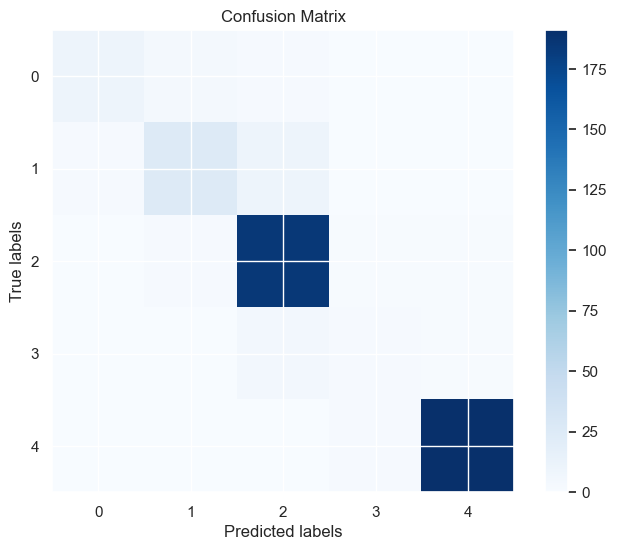

In [209]:
import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
MLFLOW_TRACKING_URI="https://dagshub.com/pranavi.chintala05/seattle_weather_prediction.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="pranavi.chintala05"
os.environ['MLFLOW_TRACKING_PASSWORD']="12345678"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)



# Create a new MLflow Experiment
mlflow.set_experiment("Predict Seattle Weather")

# Instantiate Preprocessor_fe and fit it to the data
preprocessor = Preprocessor_fe()
preprocessor.fit(X_train_fe)

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_log)

    # Log metrics
    mlflow.log_metric('recall_score', recalls[3])
    mlflow.log_metric('f1_score', f1_scores[3])
    mlflow.log_metric("precision_score", precisions[3])
    mlflow.log_metric("Accuracy", accuracies[3])
    mlflow.log_metric("roc_auc_score", roc_auc_scores[3])
    
    
    
    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Logistic Regression model")
    

    # Infer the model signature
    signature = infer_signature(X_train_fe, logistic_pipeline.predict(X_train_fe))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=logistic_pipeline,
        artifact_path="seattle_weather_model",
        signature=signature,
        input_example=preprocessor.transform(X_train_fe),
        registered_model_name="Logistic model",
    )
    y_pred = logistic_pipeline.predict(X_test_fe)
    
    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_fe, y_pred)
    true_negatives = conf_matrix[0][0]
    false_positives = conf_matrix[0][1]
    false_negatives = conf_matrix[1][0]
    true_positives = conf_matrix[1][1]


    # Log the metrics
    mlflow.log_metric("true_negatives", true_negatives)
    mlflow.log_metric("false_positives", false_positives)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("true_positives", true_positives)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    # Save the confusion matrix plot as an image file
    conf_matrix_image_path = "logistic_pipeline_confusion_matrix.png"
    plt.savefig(conf_matrix_image_path)
    plt.show()
    plt.close()

    mlflow.log_artifact(conf_matrix_image_path, "logistic_pipeline_confusion_matrix")
    


In [210]:
params_rf = rfc_pipeline.get_params()
params_rf

{'memory': None,
 'steps': [('preprocessor_fe', Preprocessor_fe()),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'preprocessor_fe': Preprocessor_fe(),
 'randomforestclassifier': RandomForestClassifier(),
 'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__ccp_alpha': 0.0,
 'randomforestclassifier__class_weight': None,
 'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': None,
 'randomforestclassifier__max_features': 'sqrt',
 'randomforestclassifier__max_leaf_nodes': None,
 'randomforestclassifier__max_samples': None,
 'randomforestclassifier__min_impurity_decrease': 0.0,
 'randomforestclassifier__min_samples_leaf': 1,
 'randomforestclassifier__min_samples_split': 2,
 'randomforestclassifier__min_weight_fraction_leaf': 0.0,
 'randomforestclassifier__n_estimators': 100,
 'randomforestclassifier__n_jobs': None,
 'randomforestclassifier__oob_score': False,
 'randomforestclassifier__random_state': None,
 'rando

Preprocessor_fe()

/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Random Forest model'.
2024/05/17 02:29:59 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Random Forest model, version

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 0, 'Predicted labels')

Text(0, 0.5, 'True labels')

([<matplotlib.axis.XTick at 0x2a47d5350>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Positive')])

([<matplotlib.axis.YTick at 0x2a45f8610>,
 [Text(0, 0, 'Negative'), Text(0, 1, 'Positive')])

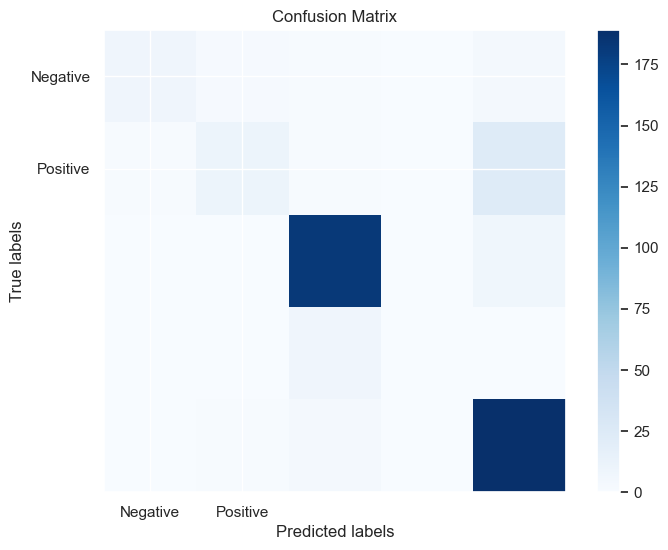

In [211]:
import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
MLFLOW_TRACKING_URI="https://dagshub.com/pranavi.chintala05/seattle_weather_prediction.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="pranavi.chintala05"
os.environ['MLFLOW_TRACKING_PASSWORD']="12345678"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Instantiate Preprocessor_fe and fit it to the data
preprocessor = Preprocessor_fe()
preprocessor.fit(X_train_fe)

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_rf)

    # Log metrics
    mlflow.log_metric('recall_score', recalls[0])
    mlflow.log_metric('f1_score', f1_scores[0])
    mlflow.log_metric("precision_score", precisions[0])
    mlflow.log_metric("Accuracy", accuracies[0])
    mlflow.log_metric("roc_auc_score", roc_auc_scores[0])
    

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Random Forest Model")


    # Infer the model signature
    signature = infer_signature(X_train_fe, rfc_pipeline.predict(X_train_fe))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=rfc_pipeline,
        artifact_path="seattle_weather_model",
        signature=signature,
        input_example=preprocessor.transform(X_train_fe),
        registered_model_name="Random Forest model",
    )
    y_pred = rfc_pipeline.predict(X_test_fe)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_fe, y_pred)
    true_negatives = conf_matrix[0][0]
    false_positives = conf_matrix[0][1]
    false_negatives = conf_matrix[1][0]
    true_positives = conf_matrix[1][1]

    # Log the metrics
    mlflow.log_metric("true_negatives", true_negatives)
    mlflow.log_metric("false_positives", false_positives)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("true_positives", true_positives)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

    # Save the confusion matrix plot as an image file
    conf_matrix_image_path = "rfc_confusion_matrix.png"
    plt.savefig(conf_matrix_image_path)

    # Log the confusion matrix image as a custom metric in MLflow
    mlflow.log_artifact(conf_matrix_image_path, "rfc_confusion_matrix")

In [212]:
params_svm = svm_pipeline.get_params()
params_svm

{'memory': None,
 'steps': [('preprocessor_fe', Preprocessor_fe()),
  ('standardscaler', StandardScaler()),
  ('svc', SVC(probability=True))],
 'verbose': False,
 'preprocessor_fe': Preprocessor_fe(),
 'standardscaler': StandardScaler(),
 'svc': SVC(probability=True),
 'standardscaler__copy': True,
 'standardscaler__with_mean': True,
 'standardscaler__with_std': True,
 'svc__C': 1.0,
 'svc__break_ties': False,
 'svc__cache_size': 200,
 'svc__class_weight': None,
 'svc__coef0': 0.0,
 'svc__decision_function_shape': 'ovr',
 'svc__degree': 3,
 'svc__gamma': 'scale',
 'svc__kernel': 'rbf',
 'svc__max_iter': -1,
 'svc__probability': True,
 'svc__random_state': None,
 'svc__shrinking': True,
 'svc__tol': 0.001,
 'svc__verbose': False}

Preprocessor_fe()

/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Support Vector model'.
2024/05/17 02:30:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Support Vector model, versi

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 0, 'Predicted labels')

Text(0, 0.5, 'True labels')

([<matplotlib.axis.XTick at 0x2a487d5d0>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Positive')])

([<matplotlib.axis.YTick at 0x2aaf45210>,
 [Text(0, 0, 'Negative'), Text(0, 1, 'Positive')])

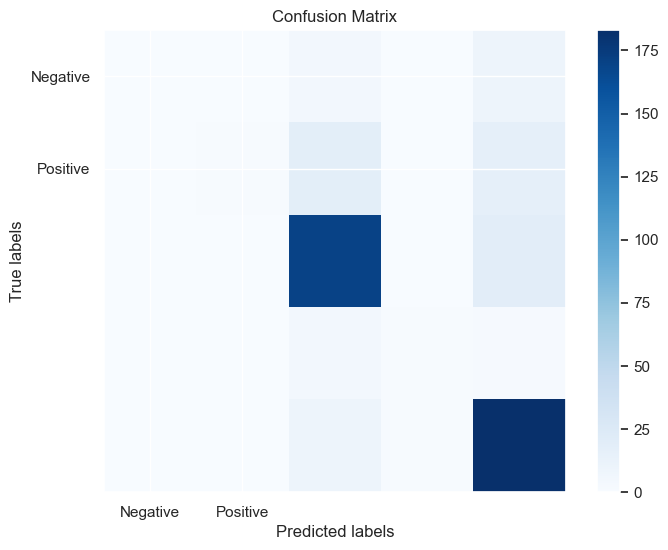

In [213]:
import mlflow
from mlflow.models import infer_signature

# Set our tracking server uri for logging
# Set our tracking server uri for logging
MLFLOW_TRACKING_URI="https://dagshub.com/pranavi.chintala05/seattle_weather_prediction.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="pranavi.chintala05"
os.environ['MLFLOW_TRACKING_PASSWORD']="12345678"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
# Instantiate Preprocessor_fe and fit it to the data
preprocessor = Preprocessor_fe()
preprocessor.fit(X_train_fe)

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_svm)

    # Log metrics
    mlflow.log_metric('recall_score', recalls[1])
    mlflow.log_metric('f1_score', f1_scores[1])
    mlflow.log_metric("precision_score", precisions[1])
    mlflow.log_metric("Accuracy", accuracies[1])
    mlflow.log_metric("roc_auc_score", roc_auc_scores[1])
    

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Support Vector model")


    # Infer the model signature
    signature = infer_signature(X_train_fe, svm_pipeline.predict(X_train_fe))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model=svm_pipeline,
        artifact_path="seattle_weather_model",
        signature=signature,
        input_example=preprocessor.transform(X_train_fe),
        registered_model_name="Support Vector model",
    )
    y_pred = svm_pipeline.predict(X_test_fe)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_fe, y_pred)
    true_negatives = conf_matrix[0][0]
    false_positives = conf_matrix[0][1]
    false_negatives = conf_matrix[1][0]
    true_positives = conf_matrix[1][1]

    # Log the metrics
    mlflow.log_metric("true_negatives", true_negatives)
    mlflow.log_metric("false_positives", false_positives)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("true_positives", true_positives)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

    # Save the confusion matrix plot as an image file
    conf_matrix_image_path = "svm_confusion_matrix.png"
    plt.savefig(conf_matrix_image_path)

    # Log the confusion matrix image as a custom metric in MLflow
    mlflow.log_artifact(conf_matrix_image_path, "svm_confusion_matrix")


In [214]:
params_nb = nb_pipeline.get_params()
params_nb

{'memory': None,
 'steps': [('preprocessor_fe', Preprocessor_fe()),
  ('gaussiannb', GaussianNB())],
 'verbose': False,
 'preprocessor_fe': Preprocessor_fe(),
 'gaussiannb': GaussianNB(),
 'gaussiannb__priors': None,
 'gaussiannb__var_smoothing': 1e-09}

Preprocessor_fe()

/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Registered model 'Naive Bayes model' already exists. Creating a new version of this model...
2024/05/17 02:30:23 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. 

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 0, 'Predicted labels')

Text(0, 0.5, 'True labels')

([<matplotlib.axis.XTick at 0x2a485a590>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Positive')])

([<matplotlib.axis.YTick at 0x2a4880850>,
 [Text(0, 0, 'Negative'), Text(0, 1, 'Positive')])

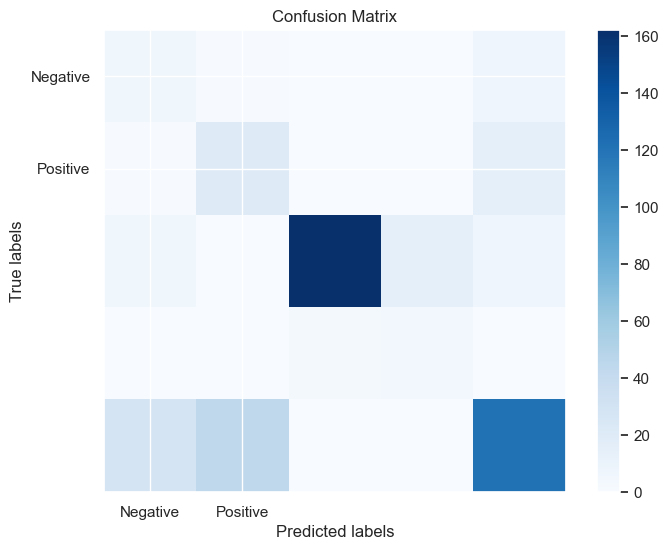

In [215]:
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import confusion_matrix


# Set our tracking server uri for logging
# Set our tracking server uri for logging
MLFLOW_TRACKING_URI="https://dagshub.com/pranavi.chintala05/predict_seattle_weather.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="pranavi.chintala05"
os.environ['MLFLOW_TRACKING_PASSWORD']="12345678"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Instantiate Preprocessor_fe and fit it to the data
preprocessor = Preprocessor_fe()
preprocessor.fit(X_train_fe)

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_nb)
    # Log metrics
    mlflow.log_metric('recall_score', recalls[2])
    mlflow.log_metric('f1_score', f1_scores[2])
    mlflow.log_metric("precision_score", precisions[2])
    mlflow.log_metric("Accuracy", accuracies[2])
    mlflow.log_metric("roc_auc_score", roc_auc_scores[2])
    

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Naive Bayes model")


    # Infer the model signature
    signature = infer_signature(X_train_fe,  nb_pipeline.predict(X_train_fe))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model= nb_pipeline,
        artifact_path="seattle_weather_model",
        signature=signature,
        input_example=preprocessor.transform(X_train_fe),
        registered_model_name="Naive Bayes model",
    )
    y_pred = nb_pipeline.predict(X_test_fe)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_fe, y_pred)
    true_negatives = conf_matrix[0][0]
    false_positives = conf_matrix[0][1]
    false_negatives = conf_matrix[1][0]
    true_positives = conf_matrix[1][1]

    # Log the metrics
    mlflow.log_metric("true_negatives", true_negatives)
    mlflow.log_metric("false_positives", false_positives)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("true_positives", true_positives)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

    # Save the confusion matrix plot as an image file
    conf_matrix_image_path = "nb_confusion_matrix.png"
    plt.savefig(conf_matrix_image_path)

    # Log the confusion matrix image as a custom metric in MLflow
    mlflow.log_artifact(conf_matrix_image_path, "nb_confusion_matrix")

In [216]:
params_dt = dt_pipeline.get_params()
params_dt

{'memory': None,
 'steps': [('preprocessor_fe', Preprocessor_fe()),
  ('decisiontreeclassifier', DecisionTreeClassifier())],
 'verbose': False,
 'preprocessor_fe': Preprocessor_fe(),
 'decisiontreeclassifier': DecisionTreeClassifier(),
 'decisiontreeclassifier__ccp_alpha': 0.0,
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': None,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__random_state': None,
 'decisiontreeclassifier__splitter': 'best'}

Preprocessor_fe()

/Users/pranavichintala/anaconda3/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'Decision Tree model'.
2024/05/17 02:30:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Decision Tree model, version

<Figure size 800x600 with 0 Axes>

Text(0.5, 1.0, 'Confusion Matrix')

Text(0.5, 0, 'Predicted labels')

Text(0, 0.5, 'True labels')

([<matplotlib.axis.XTick at 0x2a4989910>,
 [Text(0, 0, 'Negative'), Text(1, 0, 'Positive')])

([<matplotlib.axis.YTick at 0x2a490ec50>,
 [Text(0, 0, 'Negative'), Text(0, 1, 'Positive')])

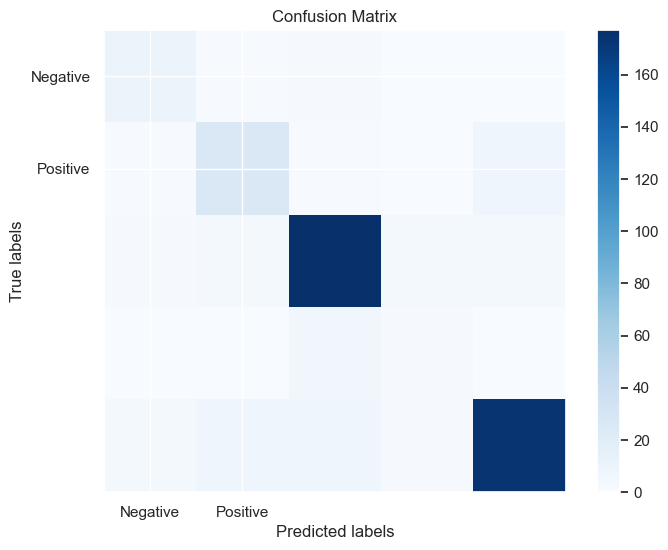

In [217]:
import mlflow
from mlflow.models import infer_signature
from sklearn.metrics import confusion_matrix


# Set our tracking server uri for logging
# Set our tracking server uri for logging
MLFLOW_TRACKING_URI="https://dagshub.com/pranavi.chintala05/seattle_weather_prediction.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME']="pranavi.chintala05"
os.environ['MLFLOW_TRACKING_PASSWORD']="12345678"

# Set our tracking server uri for logging
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)

# Instantiate Preprocessor_fe and fit it to the data
preprocessor = Preprocessor_fe()
preprocessor.fit(X_train_fe)

# Start an MLflow run
with mlflow.start_run():
    # Log the hyperparameters
    mlflow.log_params(params_dt)
    # Log metrics
    mlflow.log_metric('recall_score', recalls[2])
    mlflow.log_metric('f1_score', f1_scores[2])
    mlflow.log_metric("precision_score", precisions[2])
    mlflow.log_metric("Accuracy", accuracies[2])
    mlflow.log_metric("roc_auc_score", roc_auc_scores[2])
    

    # Set a tag that we can use to remind ourselves what this run was for
    mlflow.set_tag("Training Info", "Decision Tree model")


    # Infer the model signature
    signature = infer_signature(X_train_fe,  dt_pipeline.predict(X_train_fe))

    # Log the model
    model_info = mlflow.sklearn.log_model(
        sk_model= dt_pipeline,
        artifact_path="seattle_weather_model",
        signature=signature,
        input_example=preprocessor.transform(X_train_fe),
        registered_model_name="Decision Tree model",
    )
    y_pred = dt_pipeline.predict(X_test_fe)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test_fe, y_pred)
    true_negatives = conf_matrix[0][0]
    false_positives = conf_matrix[0][1]
    false_negatives = conf_matrix[1][0]
    true_positives = conf_matrix[1][1]

    # Log the metrics
    mlflow.log_metric("true_negatives", true_negatives)
    mlflow.log_metric("false_positives", false_positives)
    mlflow.log_metric("false_negatives", false_negatives)
    mlflow.log_metric("true_positives", true_positives)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.xticks(np.arange(2), ['Negative', 'Positive'])
    plt.yticks(np.arange(2), ['Negative', 'Positive'])

    # Save the confusion matrix plot as an image file
    conf_matrix_image_path = "dt_confusion_matrix.png"
    plt.savefig(conf_matrix_image_path)

    # Log the confusion matrix image as a custom metric in MLflow
    mlflow.log_artifact(conf_matrix_image_path, "dt_confusion_matrix")